In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import Dataset, random_split
from collections import Counter
import numpy as np
import math
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.colors import Normalize
import pandas as pd
import ast
from src.transformer import *

# %%
save_dir = Path('empirics/histogram')
save_dir.mkdir(exist_ok=True, parents=True)
device = 'cuda:0'

In [2]:
model_types = ['only_pos','only_sem']
seq_len = 10
T = 15
p = 128
model_dim = 64
n_classes = seq_len+1
L = seq_len

In [3]:
results = pd.read_csv(save_dir / 'frozen_transformer_result.csv')
results.train_losses = results.train_losses.apply(ast.literal_eval)
results.val_losses = results.val_losses.apply(ast.literal_eval)
results.val_acc = results.val_acc.apply(ast.literal_eval)

only_pos 0.9989867051865191 0.0003667068536089475


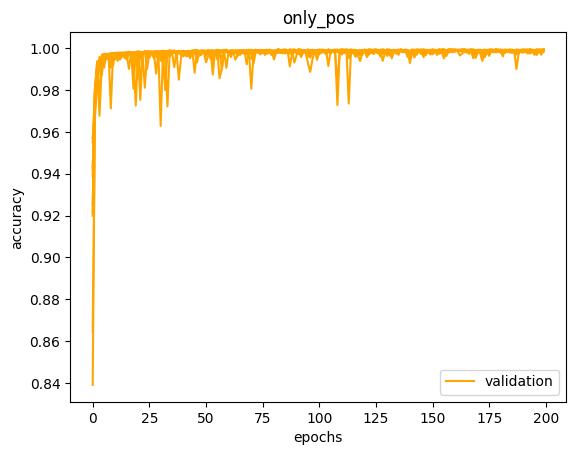

only_sem 0.9991349748854942 0.0010739957614552696


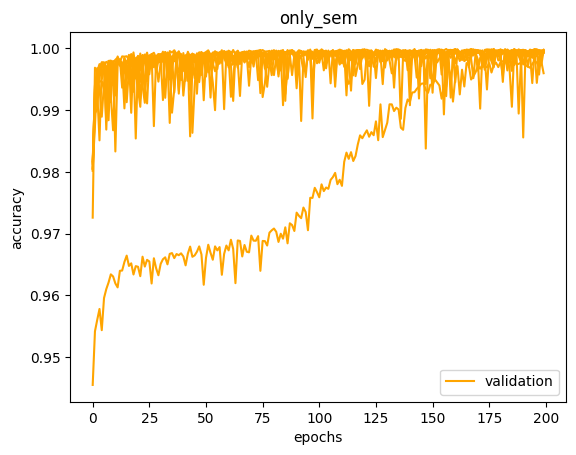

In [4]:
for model_type, g in results.groupby('model_type'):
  acc = []
  for i,row in g.iterrows():
    plt.plot(row['val_acc'],c='orange')
    acc.append(row['val_acc'][-1])
  print(model_type, np.mean(acc), np.std(acc))
  plt.plot([],[],c='orange',label='validation')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend();
  plt.title(model_type)
  # GL
  # plt.savefig( f'../figures/losses_{model_type}.png')
  plt.savefig( f'figures/losses_{model_type}.png')
  #
  plt.show()

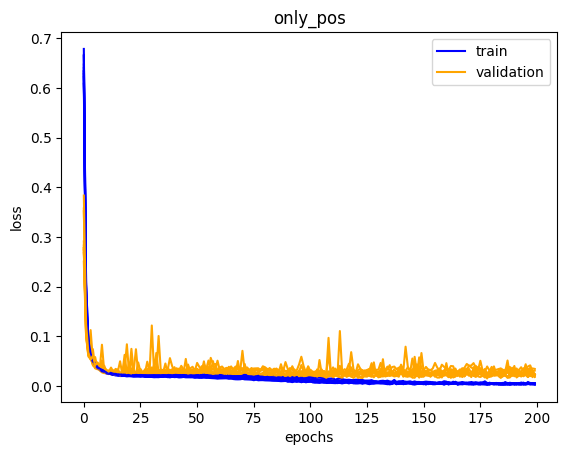

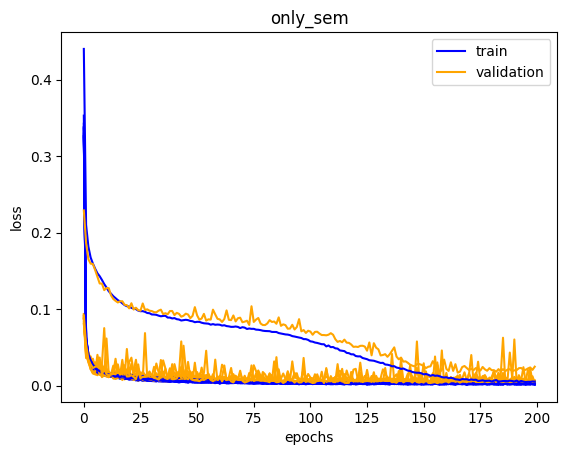

In [5]:


for model_type, g in results.groupby('model_type'):
  for i,row in g.iterrows():
    plt.plot(row['train_losses'],c='blue')
    plt.plot(row['val_losses'],c='orange')
  plt.plot([],[],c='blue',label='train')
  plt.plot([],[],c='orange',label='validation')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend();
  plt.title(model_type)
  # GL
  # plt.savefig( f'../figures/losses_{model_type}.png')
  plt.savefig( f'figures/losses_{model_type}.png')
  #
  plt.show()

In [6]:

def highlight_cell(x,y,color,transformer,ax):
    # Given a coordinate (x,y), highlight the corresponding cell using a colored frame in the ac
    # after having called imshow already
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False,color=color,lw=2)
    ax.add_patch(rect)
    return rect

def visualize_attention_matrix(x, transformer, ax, cmap='tab20b'):
  x_ = torch.tensor(x,dtype=torch.long,device=device).unsqueeze(0)
  transformer(x_)
  A = transformer.attention.attn_probs
  data = A.detach().cpu().numpy()[0]
  ax.imshow(data,vmin=0,vmax=1.0,cmap=cmap)
  for i, x_i in enumerate(x):
    for j, x_j in enumerate(x):
      if x_i == x_j:
        highlight_cell(i,j, color='red',transformer=transformer,ax=ax)
  for k in range(data.shape[0]):
          for j in range(data.shape[1]):
              ax.text(j, k, f'{int(np.round(data[k, j]*100))}', ha='center', va='center', color='white')
  alpha = 'ABCDEFGHIJKLMNOPQRSTUVW'
  ax.set_xticks(np.arange(len(x)), [alpha[a] for a in x],fontsize=13)
  ax.set_yticks(np.arange(len(x)), [alpha[a] for a in x],fontsize=13)
  ax.tick_params(axis='x', which='both', bottom=False, top=True)
  ax.xaxis.tick_top()

In [7]:
select_run = 0

only_pos
only_sem


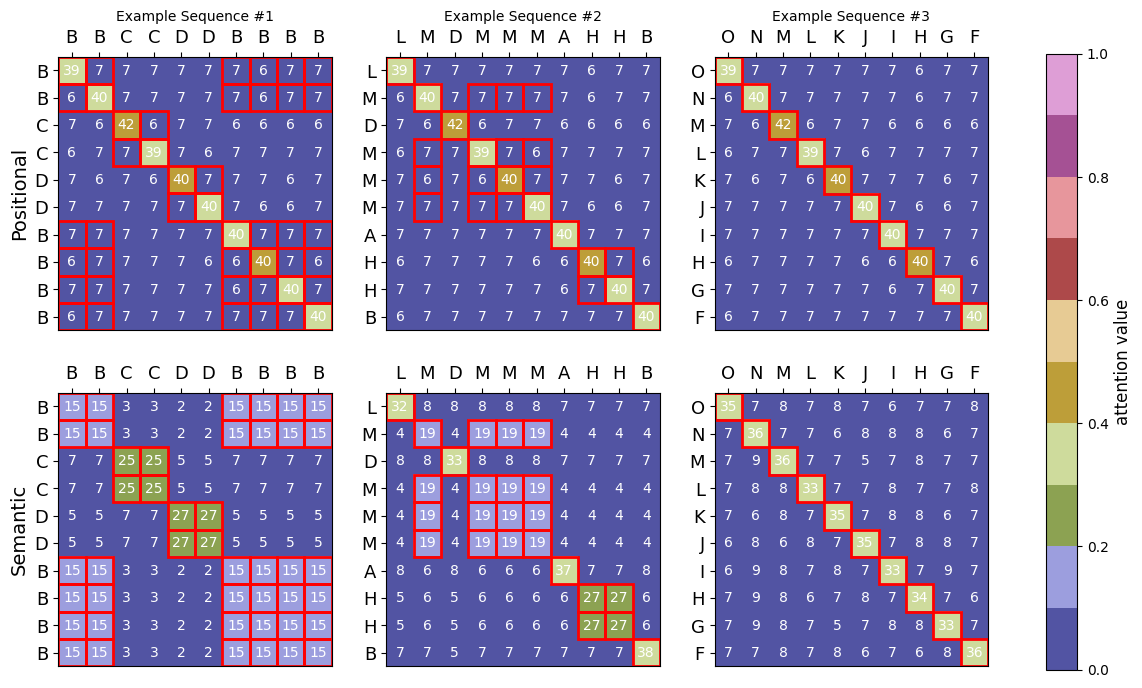

In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Extract colors from tab20b colormap
tab20b_colors = plt.cm.tab20b.colors

# Select specific colors from tab20b for your custom colormap
selected_colors = [tab20b_colors[2], tab20b_colors[6], tab20b_colors[10], tab20b_colors[14]]
selected_colors = tab20b_colors[1::2]

# Create a ListedColormap using the selected colors
custom_cmap = ListedColormap(selected_colors)


# %%
xs = [[1,1,2,2,3,3,1,1,1,1],
      [11,12,3,12,12,12,0,7,7,1],
      [14,13,12,11,10,9,8,7,6,5]]

# visualize the first run
transformer_only_pos = TransformerSeq2Seq(T,model_dim,p,n_classes,L,'only_pos').to(device)
transformer_only_pos.load_state_dict(torch.load(save_dir / f'run_{select_run}_model_only_pos_orig.pt'))
transformer_only_sem = TransformerSeq2Seq(T,model_dim,p,n_classes,L,'only_sem').to(device)
transformer_only_sem.load_state_dict(torch.load(save_dir / f'run_{select_run}_model_only_sem_orig.pt'))

transformers = [
    transformer_only_pos,
    transformer_only_sem,
]


fig, axes = plt.subplots(figsize=(15,8),ncols=3,nrows=2)
cmap = custom_cmap# 'Paired'
data = np.random.random((10, 10))
im1 = axes[0,0].imshow(data, cmap=cmap, vmin=0, vmax=1.0)
for i, transformer in enumerate(transformers):
  axes[i,0].set_ylabel("Positional" if transformer.attention_input == 'only_pos' else "Semantic", fontsize=14)
  print(transformer.attention_input)
  for j, x in enumerate(xs):
    axes[0,j].set_title(f"Example Sequence #{j+1}",fontsize=10)
    visualize_attention_matrix(x,transformer,axes[i,j],cmap=cmap)


norm = Normalize(vmin=0, vmax=1.0)
cbar = fig.colorbar(im1, ax=axes, norm=norm)
cbar.set_label('attention value',fontsize=12)
# GL
# plt.savefig(f'../figures/tiny_example.pdf',bbox_inches='tight')
plt.savefig(f'figures/tiny_example.pdf',bbox_inches='tight')
#
plt.show()

0
empirics\histogram\run_0_model_only_pos_orig.pt
only_pos
both


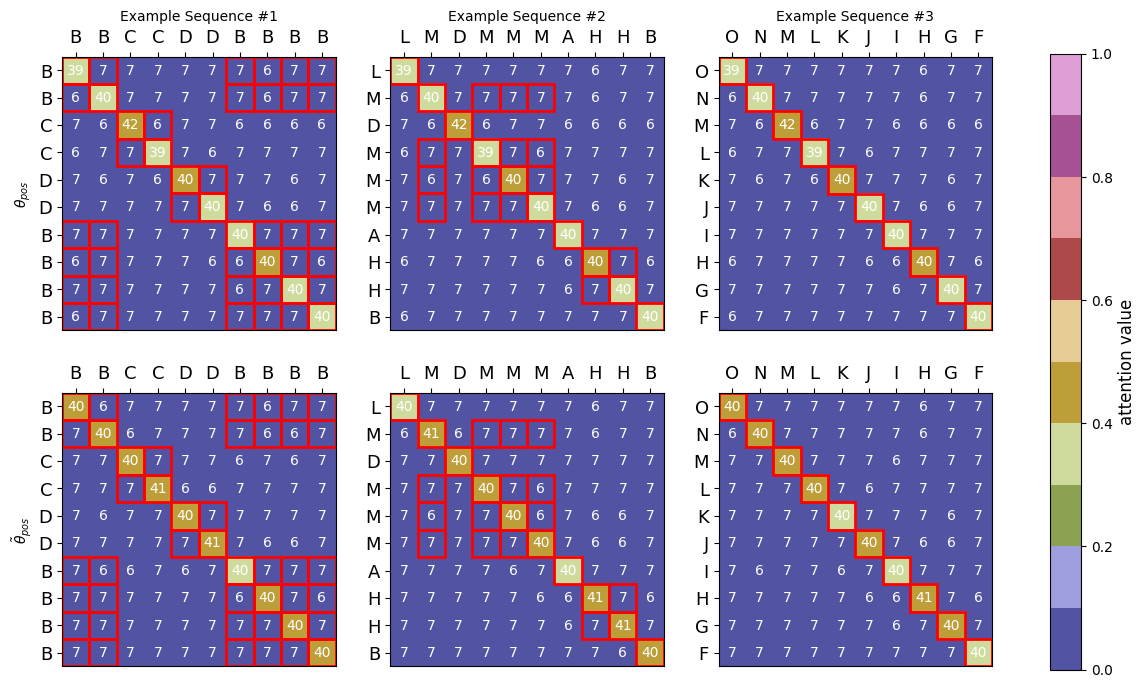

1
empirics\histogram\run_1_model_only_pos_orig.pt
only_pos
both


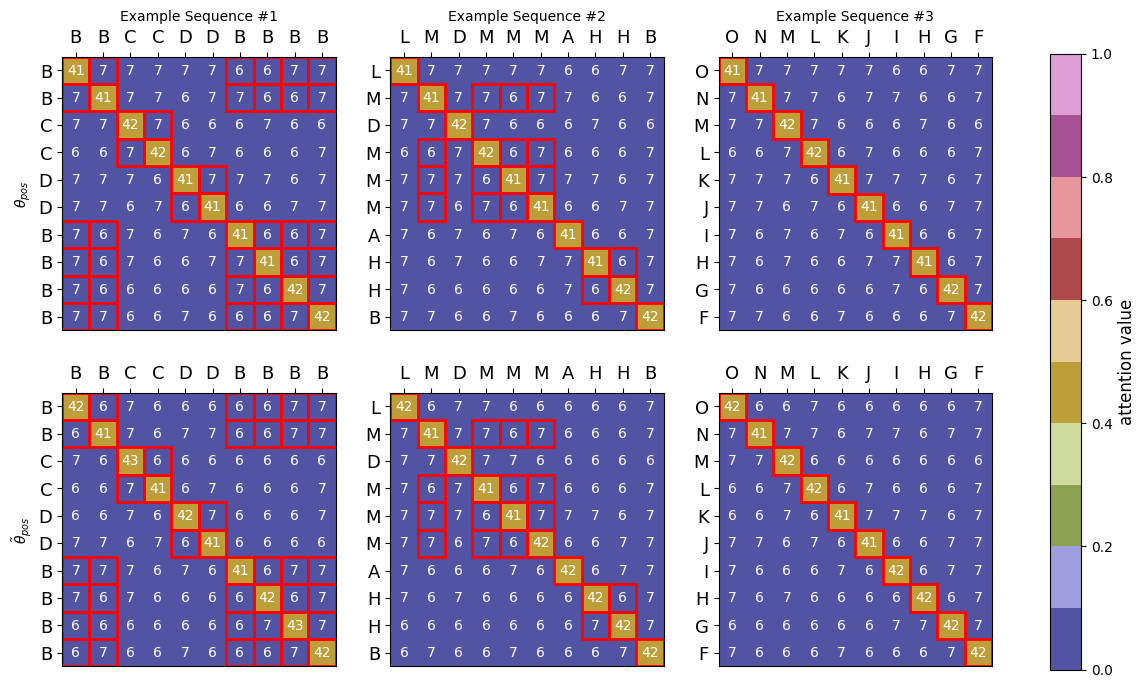

2
empirics\histogram\run_2_model_only_pos_orig.pt
only_pos
both


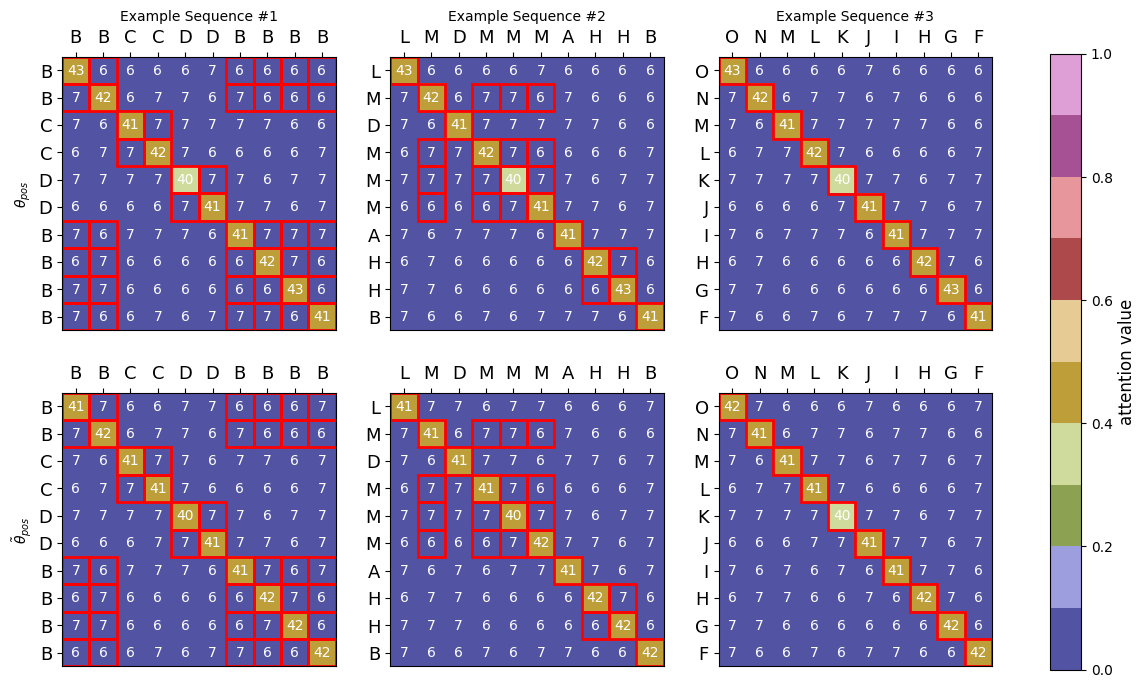

3
empirics\histogram\run_3_model_only_pos_orig.pt
only_pos
both


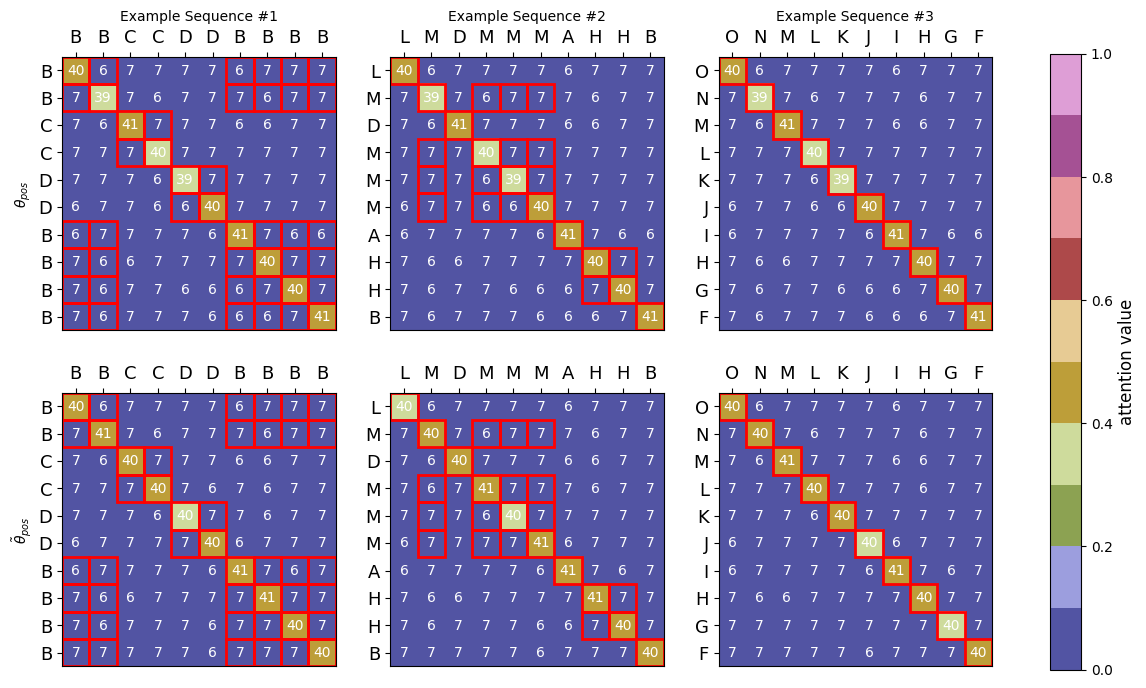

4
empirics\histogram\run_4_model_only_pos_orig.pt
only_pos
both


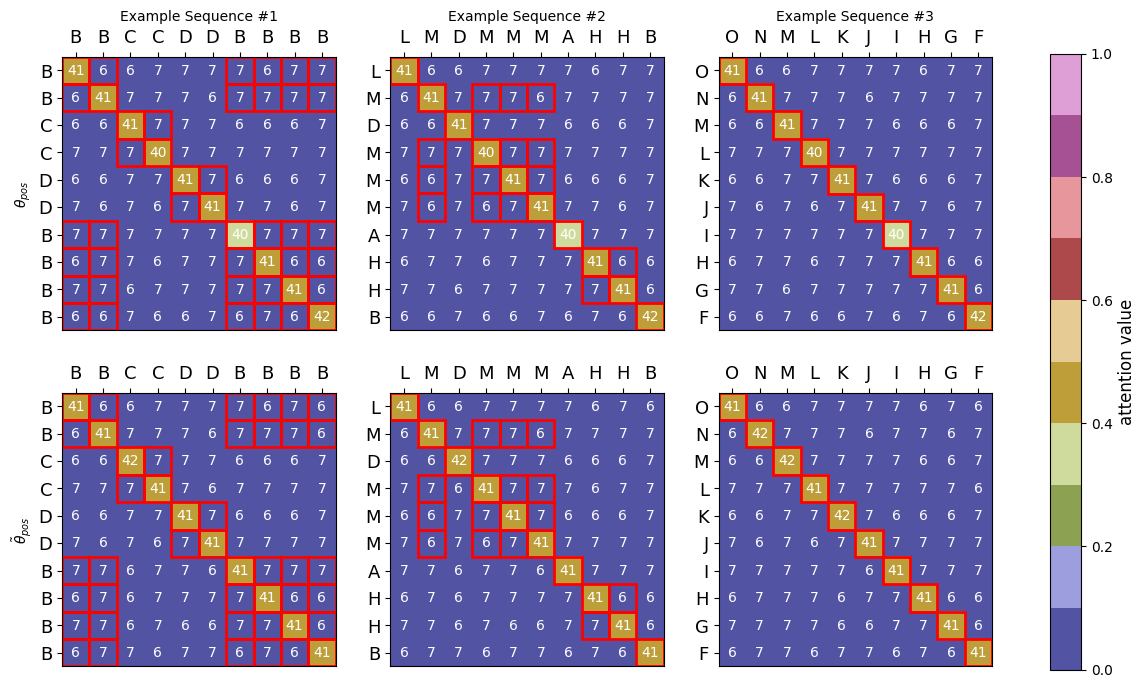

5
empirics\histogram\run_5_model_only_pos_orig.pt
only_pos
both


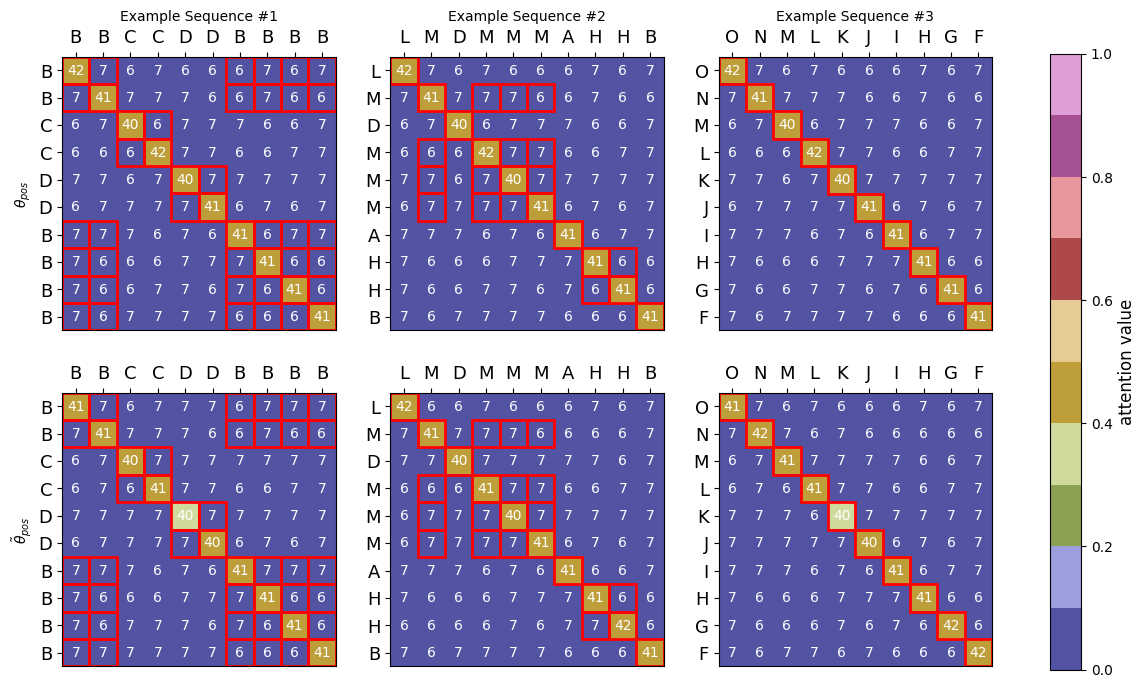

6
empirics\histogram\run_6_model_only_pos_orig.pt
only_pos
both


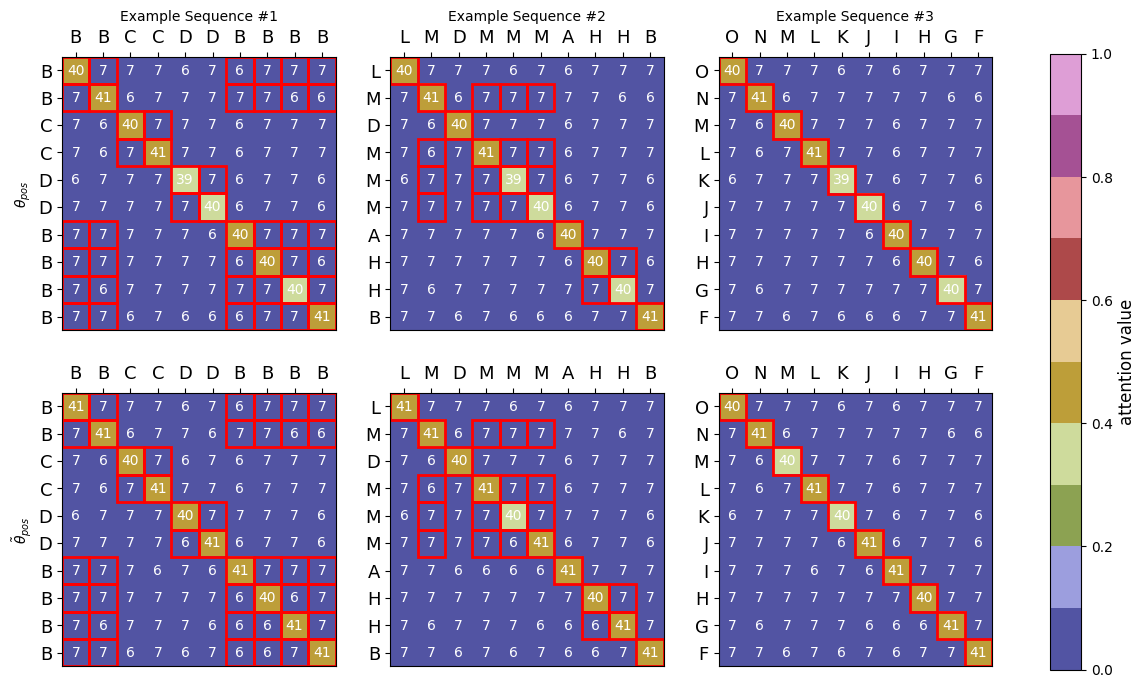

7
empirics\histogram\run_7_model_only_pos_orig.pt
only_pos
both


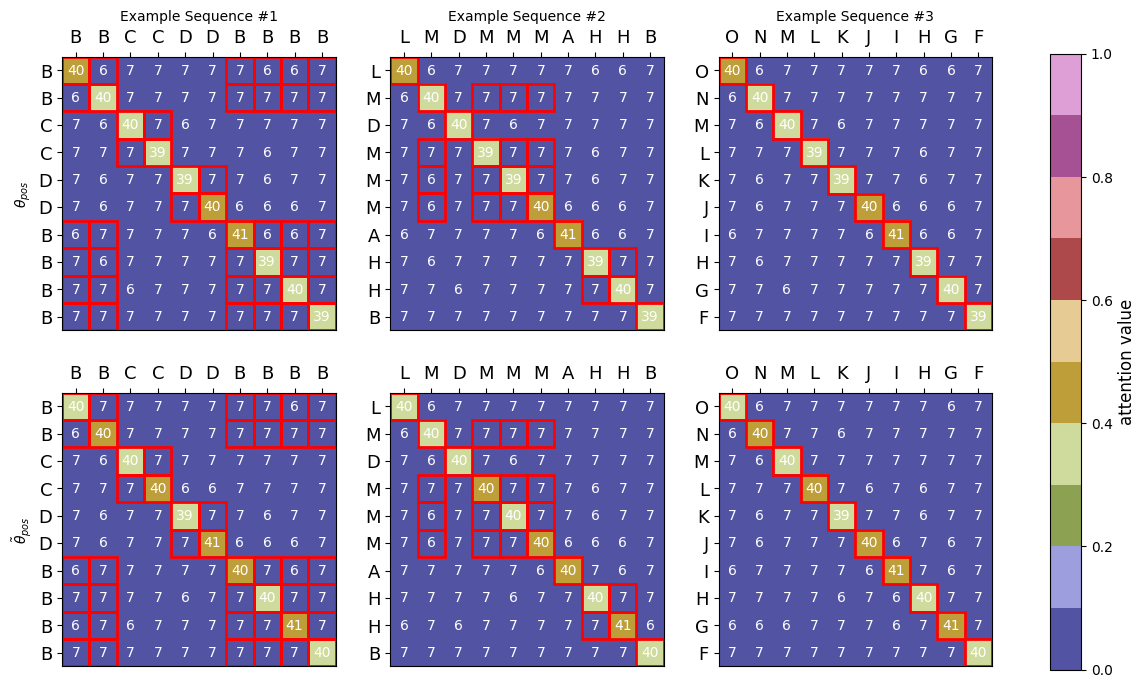

8
empirics\histogram\run_8_model_only_pos_orig.pt
only_pos
both


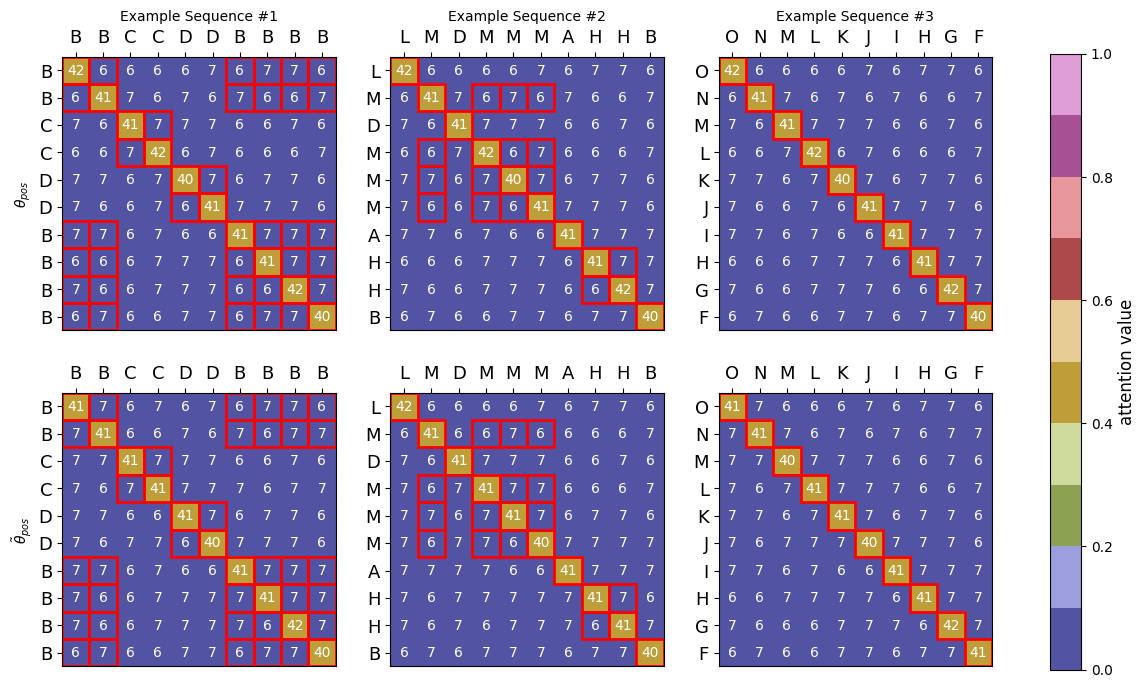

9
empirics\histogram\run_9_model_only_pos_orig.pt
only_pos
both


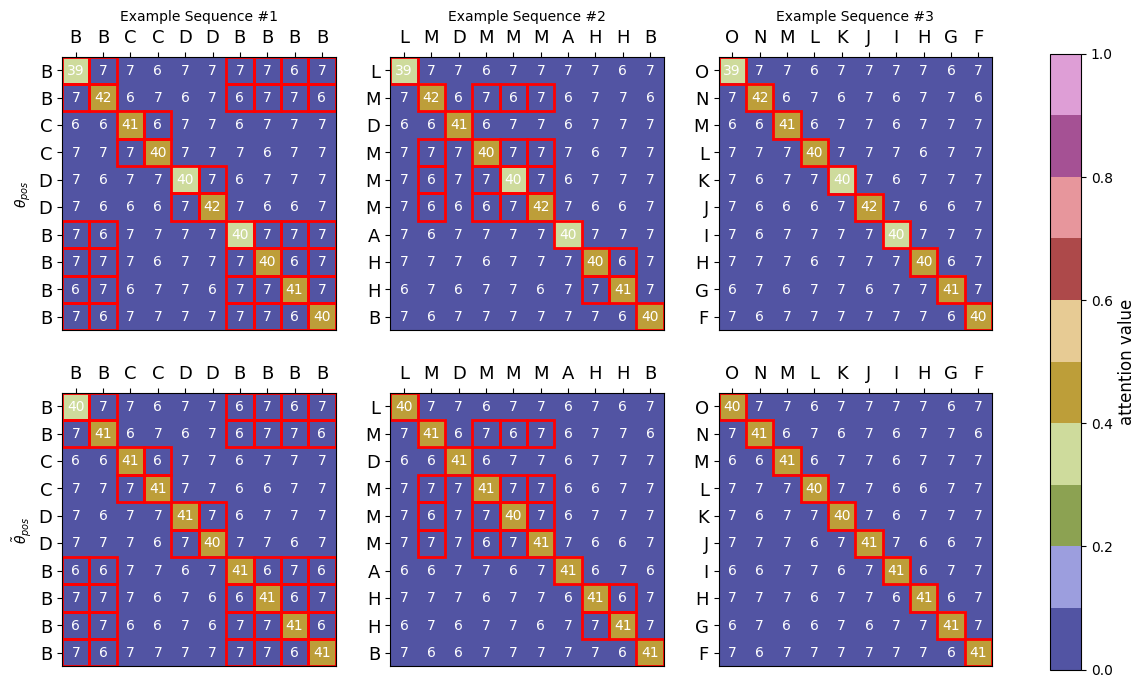

0
empirics\histogram\run_0_model_only_sem_orig.pt
only_sem
both


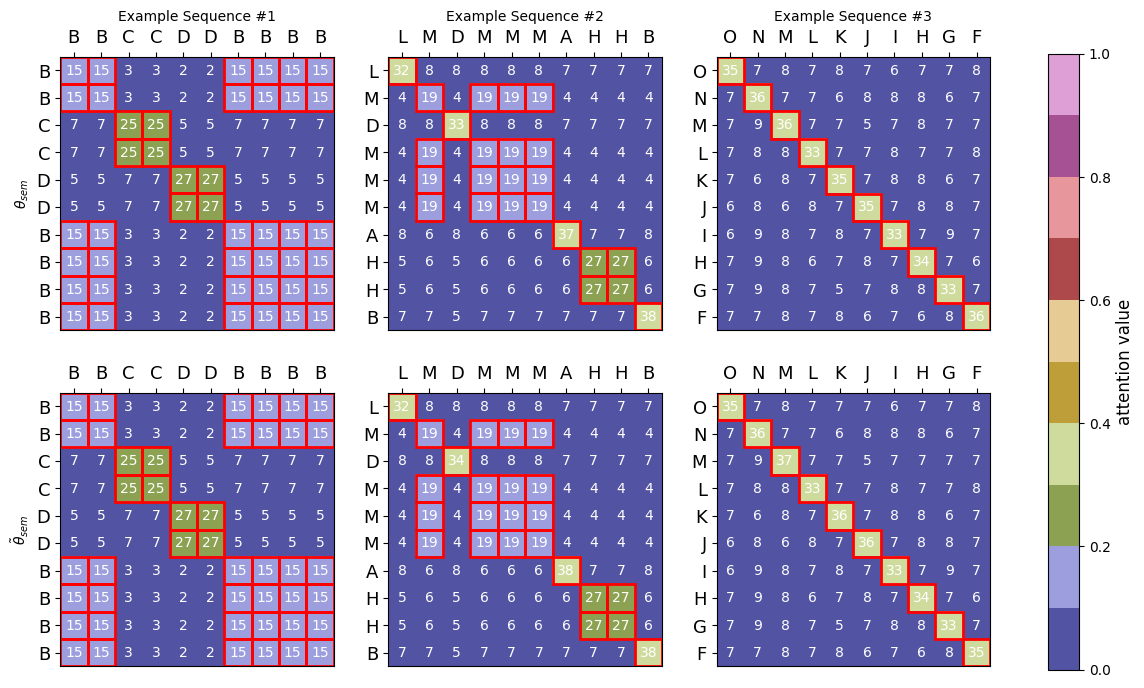

1
empirics\histogram\run_1_model_only_sem_orig.pt
only_sem
both


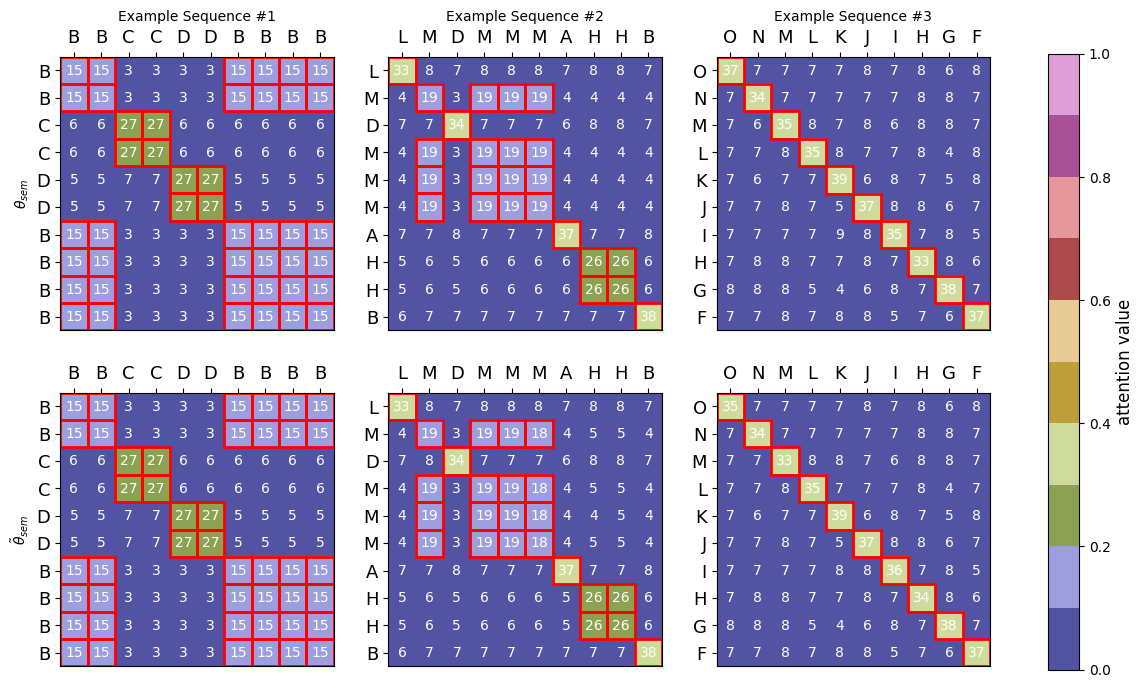

2
empirics\histogram\run_2_model_only_sem_orig.pt
only_sem
both


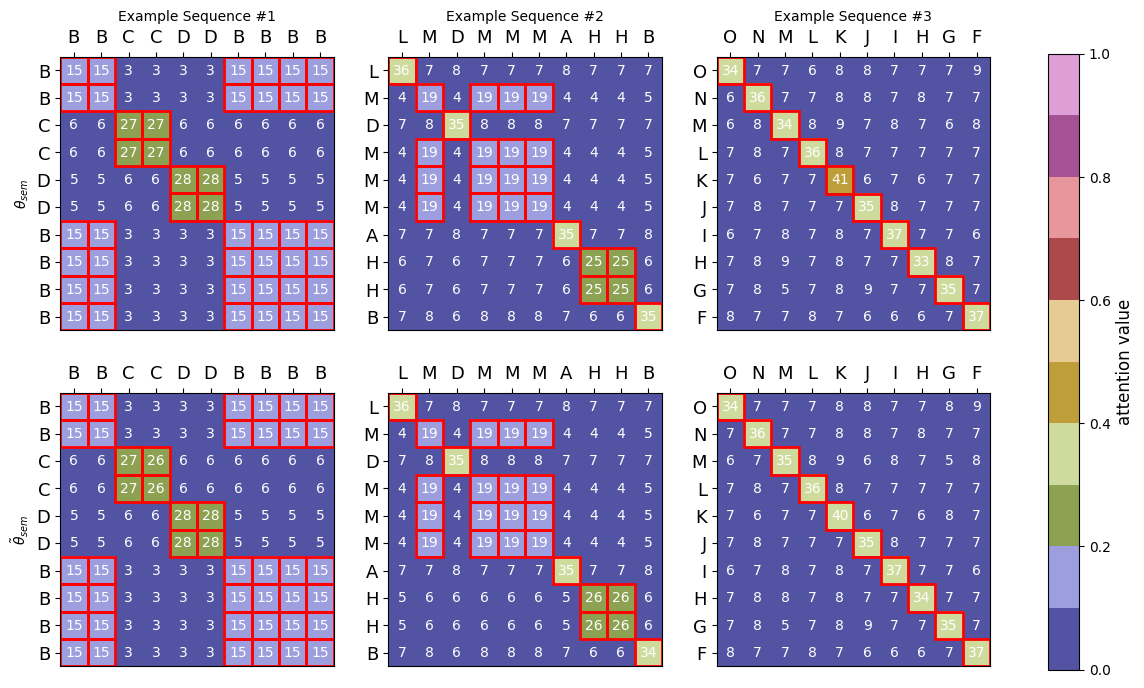

3
empirics\histogram\run_3_model_only_sem_orig.pt
only_sem
both


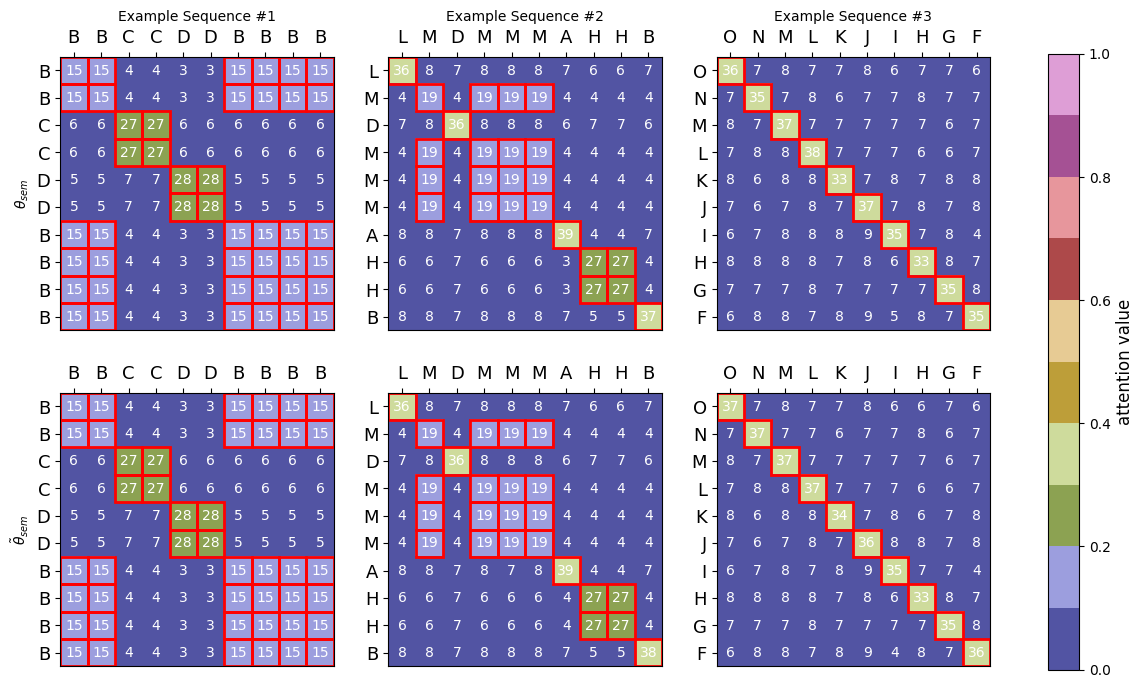

4
empirics\histogram\run_4_model_only_sem_orig.pt
only_sem
both


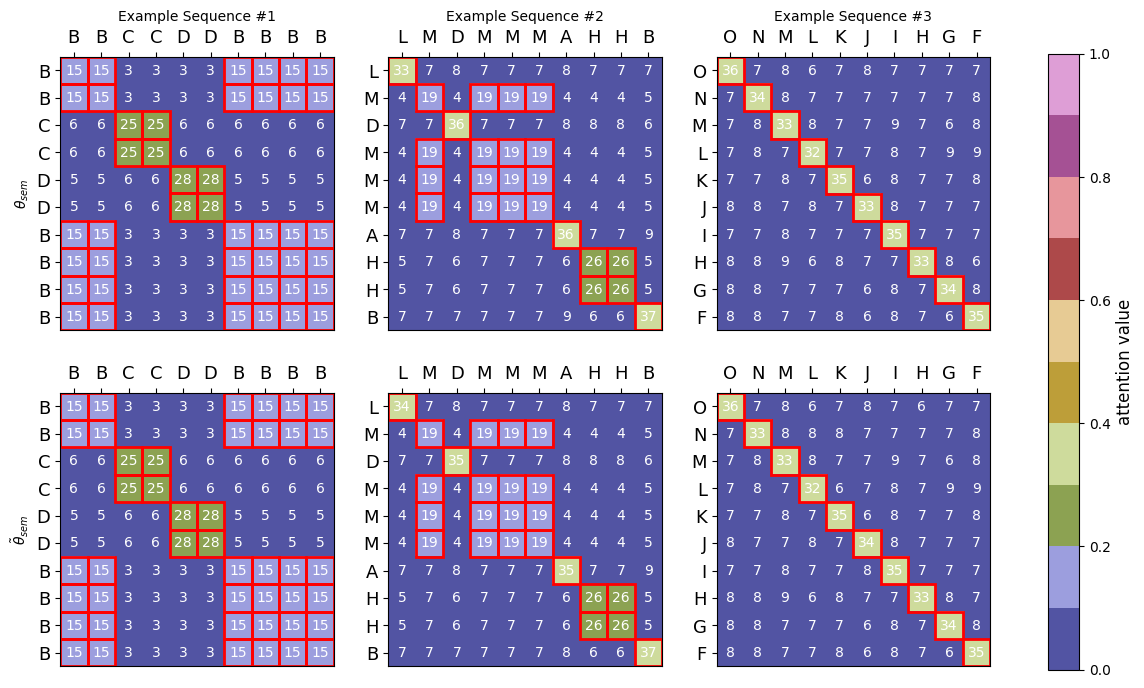

5
empirics\histogram\run_5_model_only_sem_orig.pt
only_sem
both


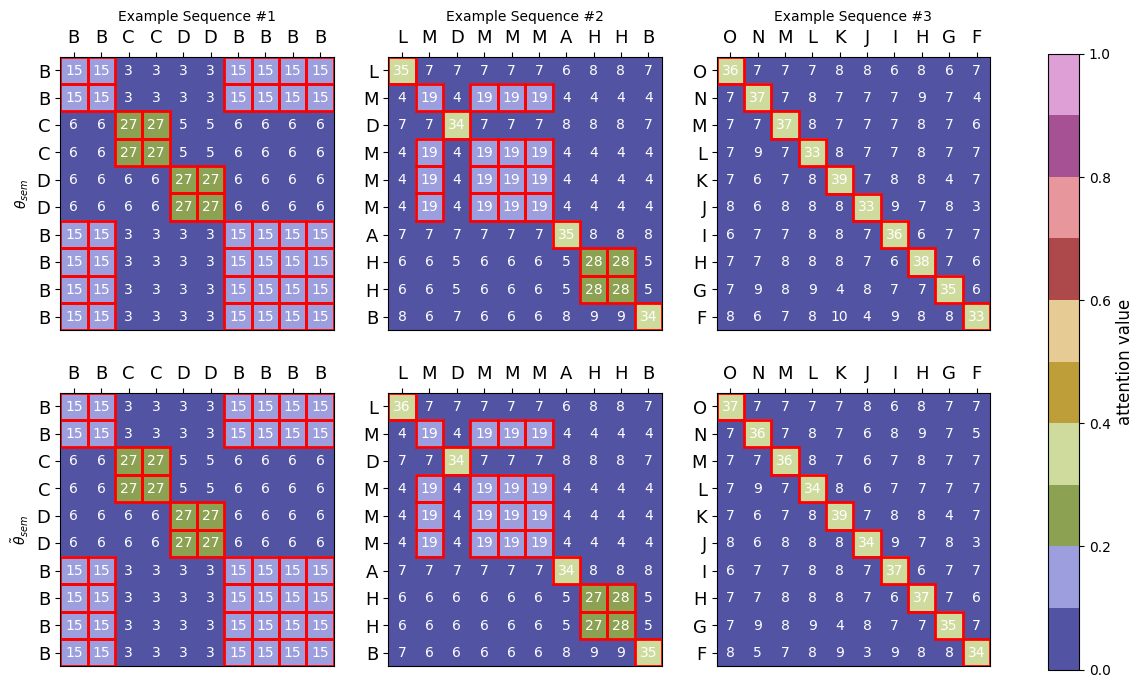

6
empirics\histogram\run_6_model_only_sem_orig.pt
only_sem
both


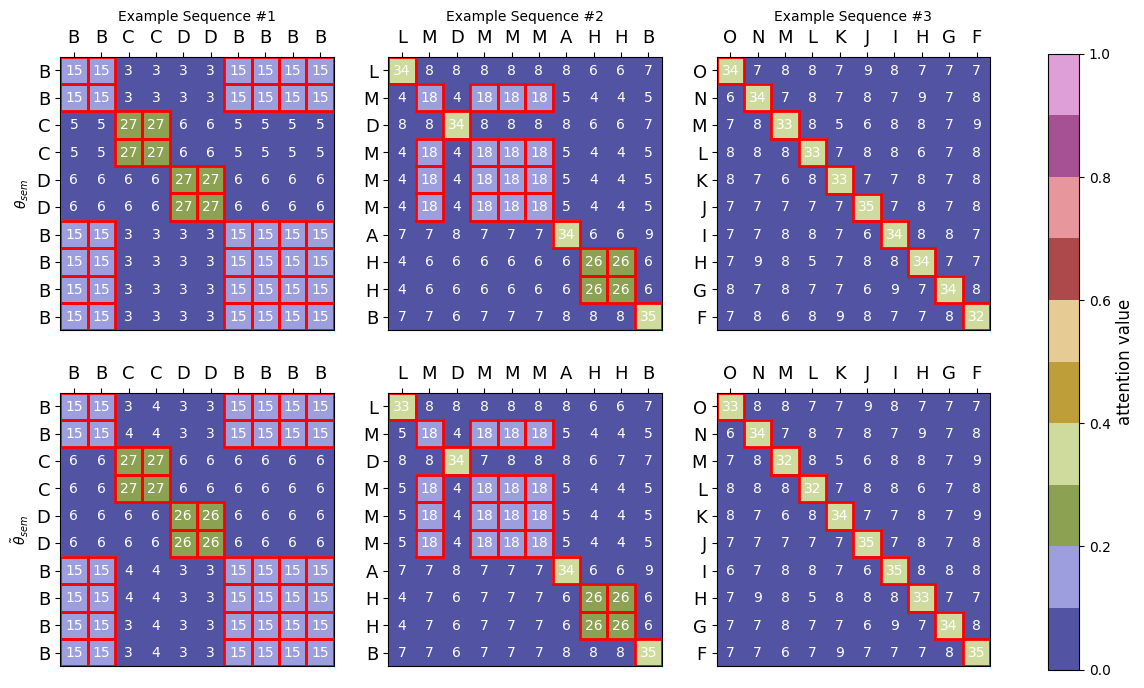

7
empirics\histogram\run_7_model_only_sem_orig.pt
only_sem
both


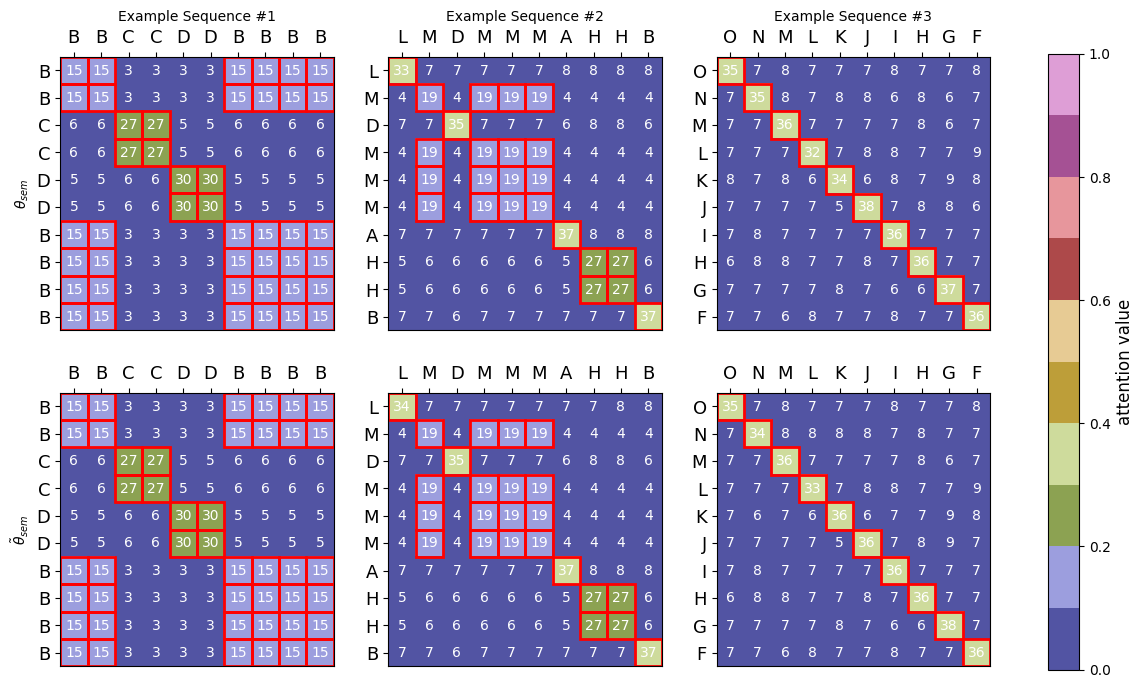

8
empirics\histogram\run_8_model_only_sem_orig.pt
only_sem
both


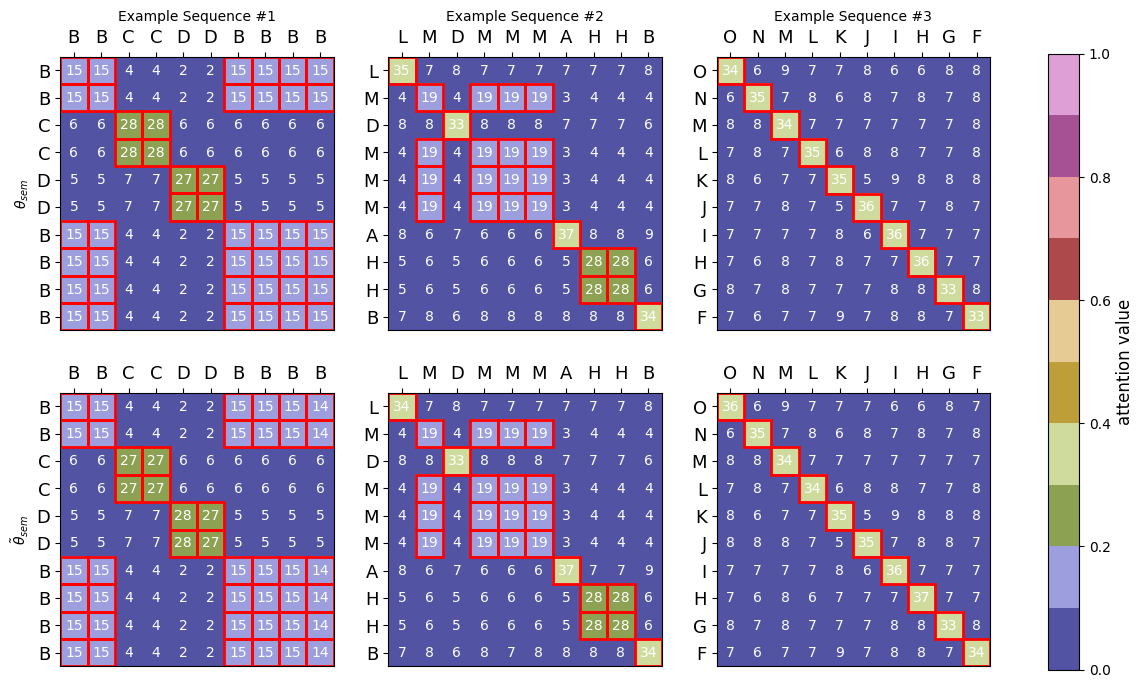

9
empirics\histogram\run_9_model_only_sem_orig.pt
only_sem
both


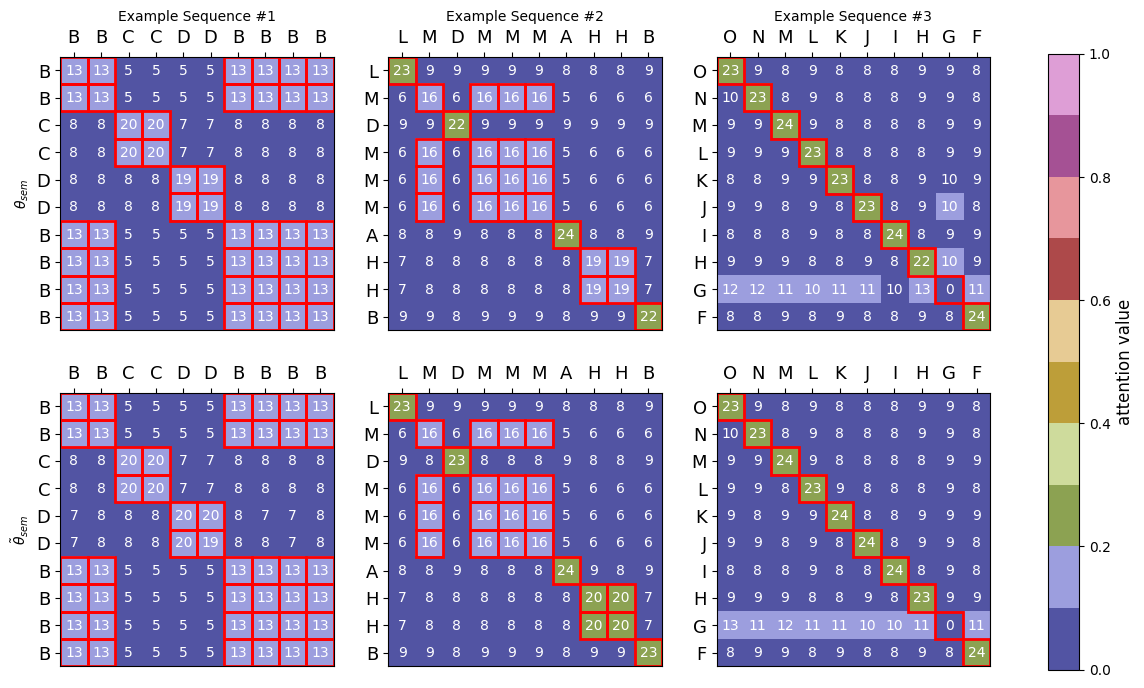

In [9]:
for model_type, g in results.groupby('model_type'):
  for i, row in g.iterrows():
    r = row['run']
    print(r)
    orig_trans = TransformerSeq2Seq(T,model_dim,p,n_classes,L,model_type).to(device)
    orig_trans.load_state_dict(torch.load(save_dir / f'run_{r}_model_{model_type}_orig.pt'))
    print(save_dir / f'run_{r}_model_{model_type}_orig.pt')
    
    reparam_trans = TransformerSeq2Seq(T,model_dim,p,n_classes,L,'both').to(device)
    reparam_trans.load_state_dict(torch.load(save_dir / f'run_{r}_model_{model_type}_retrained.pt'))
    
    transformers = [
      orig_trans,
      reparam_trans,
    ]
    
    data = np.random.random((10, 10))
    fig, axes = plt.subplots(figsize=(15,8),ncols=3,nrows=2)
    im1 = axes[0,0].imshow(data, cmap=cmap, vmin=0, vmax=1.0)
    for i, transformer in enumerate(transformers):
      print(transformer.attention_input)
      for j, x in enumerate(xs):
        axes[0,j].set_title(f"Example Sequence #{j+1}",fontsize=10)
        visualize_attention_matrix(x,transformer,axes[i,j],cmap=cmap)

    axes[0,0].set_ylabel(r'$\theta_{sem}$' if orig_trans.attention_input == 'only_sem' else r'$\theta_{pos}$')
    axes[1,0].set_ylabel(r'$\tilde{\theta}_{sem}$' if orig_trans.attention_input == 'only_sem' else r'$\tilde{\theta}_{pos}$')

    norm = Normalize(vmin=0, vmax=1.0)
    cbar = fig.colorbar(im1, ax=axes, norm=norm)
    cbar.set_label('attention value',fontsize=12)
    # GL
    # plt.savefig(f'../figures/run_{r}_training_comparison_{orig_trans.attention_input}.pdf',bbox_inches='tight')
    plt.savefig(f'figures/run_{r}_training_comparison_{orig_trans.attention_input}.pdf',bbox_inches='tight')
    #
    plt.show()

In [10]:

import torch
import torch.nn as nn

def model_distance(model1, model2, only_zeros=False):
    params1 = [param for param in model1.parameters()]
    params2 = [param for param in model2.parameters()]

    distance = 0.0
    for p1, p2 in zip(params1, params2):
        if only_zeros:
          mask = p2.flatten() == 0.0
          distance += torch.norm(p1.flatten()[mask] - p2.flatten()[mask], 2)
        else:
          distance += torch.norm(p1 - p2, 2)

    return distance.item()
  

def reparameterize(orig_transformer):
  with torch.no_grad():
    a = orig_transformer.state_dict()
    new_transformer = TransformerSeq2Seq(T,model_dim,p,n_classes,L,orig_transformer.attention_input)
    new_transformer.load_state_dict(a)
    new_transformer.attention.Q.data = new_transformer.attention.F @ new_transformer.attention.Q
    new_transformer.attention.K.data = new_transformer.attention.F @ new_transformer.attention.K
    new_transformer.semantic_emb.weight[...,int(model_dim/2):] = 0.0
    new_transformer.positional_emb.embedding.weight[...,:int(model_dim/2)] = 0.0
    a = new_transformer.state_dict()
    new_transformer = TransformerSeq2Seq(T,model_dim,p,n_classes,L,'both')
    new_transformer.load_state_dict(a)
  return new_transformer


# %%
df = []
for model_type, g in results.groupby('model_type'):
  for i, row in g.iterrows():
    r = row['run']
    
    transformer_frozen_init = TransformerSeq2Seq(T,model_dim,p,n_classes,L,model_type).to(device)
    transformer_frozen_init.load_state_dict(torch.load(save_dir / f'run_{r}_initmodel_{model_type}_orig.pt'))
    transformer_frozen_init = reparameterize(transformer_frozen_init).to(device)
    
    
    transformer_frozen = TransformerSeq2Seq(T,model_dim,p,n_classes,L,model_type).to(device)
    transformer_frozen.load_state_dict(torch.load(save_dir / f'run_{r}_model_{model_type}_orig.pt'))
    transformer_frozen = reparameterize(transformer_frozen).to(device)
    
    
    reparam_trans = TransformerSeq2Seq(T,model_dim,p,n_classes,L,'both').to(device)
    reparam_trans.load_state_dict(torch.load(save_dir / f'run_{r}_model_{model_type}_retrained.pt'))
    reparam_trans = reparameterize(reparam_trans).to(device)
        
    dist_frozen_to_SGD = model_distance(reparam_trans, transformer_frozen) 
    dist_frozen_to_SGD_zeros = model_distance(reparam_trans,transformer_frozen,only_zeros=True)
    #dist_frozen_to_SGD_zeros = model_distance(transformer_frozen,reparam_trans,only_zeros=True)
    dist_init_to_frozen = model_distance(transformer_frozen_init, transformer_frozen)
        
    df.append({
        'distance_frozen_to_SGD': dist_frozen_to_SGD,
        'distance_frozen_to_SGD_only_zeros': dist_frozen_to_SGD_zeros,
        'distance_init_to_frozen': dist_init_to_frozen,
        'model_type': model_type,
        'run': r
    })
    #plt.imshow(dist_frozen_to_SGD.attention.K.data)

df = pd.DataFrame(df)
df = df.groupby('model_type').agg(['mean','std'])
df

distance_frozen_to_SGD           distance_frozen_to_SGD_only_zeros  \
                             mean       std                              mean   
model_type                                                                      
only_pos                 0.462151  0.095772                          0.102475   
only_sem                 0.393129  0.156666                          0.097580   

                     distance_init_to_frozen             run           
                 std                    mean        std mean      std  
model_type                                                             
only_pos    0.002716              163.152608   5.437297  4.5  3.02765  
only_sem    0.010053              163.311522  12.389378  4.5  3.02765